# Subgrid topography

conda env: new `phd_v3` (in `envs/phd`)

job_big

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Check orography

In [30]:
# latlim, lonlim = u.get_zone('HMA')
# latlim_everest = slice(26.619719-0.6338, 27.887323+0.6338)
# lonlim_everest = slice(85.0-1.25, 87.5+1.25)

In [2]:
# latlim, lonlim = u.get_zone('HMA')
# latlim_everest = slice(26.619719-0.6338, 29.154919+0.6338)
# lonlim_everest = slice(85.0-1.25, 87.5+1.25)

In [42]:
29.154919+2*0.6338

30.422519

In [2]:
latlim, lonlim = u.get_zone('HMA')
latlim_everest = slice(26.619719-0.6338, 30.422519+0.6338)
lonlim_everest = slice(85.0-1.25, 90+1.25)

### NOAA NGDC GLOBE (1km)
http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.GLOBE/.topo/datafiles.html

In [3]:
topo_globe = xr.open_dataarray('/data/mlalande/Relief/Relief_NOAA_NGDC_GLOBE_topo_1km.nc').sel(latitude=slice(latlim.stop, latlim.start), longitude=lonlim).load()

### GMTED2010
http://www.temis.nl/data/gmted2010/

In [4]:
topo_gmted = xr.open_dataarray('/data/mlalande/Relief/Relief_GMTED2010_15n015_00625deg.nc').sel(latitude=latlim, longitude=lonlim).load()

In [5]:
ds = xr.open_dataset('/data/mlalande/Relief/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
            .drop(['nlat', 'nlon']).rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
ds

<xarray.Dataset>
Dimensions:           (lat: 480, lon: 800)
Coordinates:
  * lat               (lat) float32 20.03125 20.09375 ... 49.90625 49.96875
  * lon               (lon) float32 60.03125 60.09375 ... 109.90625 109.96875
Data variables:
    elevation         (lat, lon) int16 ...
    elevation_stddev  (lat, lon) int16 ...
    elevation_max     (lat, lon) int16 ...
    elevation_min     (lat, lon) int16 ...
Attributes:
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    Title:                      GMTED2010 elevation data regridded at 0.062 d...
    resolution_degrees:         0.0625
    resolution_summing_factor:  15
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    input_note:                 see "Original_attributes" for a copy of the a...
    creation_date:              2019-10-15
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...

In [6]:
topo_gmted = ds.elevation
std_gmted = ds.elevation_stddev

# Simus LR et HR
https://github.com/mickaellalande/PhD/blob/master/Jean-Zay/SCA_parameterization/ELC-144x142x79-GMTED-STD/ELC-144x142x79-GMTED-STD.ipynb

In [7]:
path_boundary = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79-GMTED-STD/ATM/Output/Boundary/'
path_grid = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79-GMTED-STD/ATM/Output/Grid/'
path_restart = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79-GMTED-STD/ATM/Output/Restart/'

startphy = xr.open_dataset(path_restart+'ELC-144x142x79-GMTED-STD_clim_startphy.nc')
grid = xr.open_dataset(path_grid+'ELC-144x142x79-GMTED-STD_grilles_gcm.nc')

topo_LR_filtered = u.phys2dyn(startphy.ZMEA, grid)
topo_LR = u.phys2dyn(startphy.ZMEA_NOT_FILTERED, grid)

std_LR_filtered = u.phys2dyn(startphy.ZSTD, grid)
std_LR = u.phys2dyn(startphy.ZSTD_NOT_FILTERED, grid)

In [8]:
path_boundary = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELI-512x360x79-GMTED-STD-amip/ATM/Output/Boundary/'
path_grid = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELI-512x360x79-GMTED-STD-amip/ATM/Output/Grid/'
path_restart = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZ/ELI-512x360x79-GMTED-STD-amip/ATM/Output/Restart/'

startphy = xr.open_dataset(path_restart+'ELI-512x360x79-GMTED-STD-amip_2004_startphy.nc')
grid = xr.open_dataset(path_grid+'ELI-512x360x79-GMTED-STD-amip_2004_grilles_gcm.nc')

# topo_HR_filtered = u.phys2dyn(startphy.ZMEA, grid)
topo_HR = u.phys2dyn(startphy.ZMEA_NOT_FILTERED, grid)

# std_HR_filtered = u.phys2dyn(startphy.ZSTD, grid)
std_HR = u.phys2dyn(startphy.ZSTD_NOT_FILTERED, grid)

# Variables

In [9]:
period_clim = slice('1982', '2014')

In [10]:
# For parallelisation
from dask.distributed import Client
from dask import compute
client = Client(n_workers=8, threads_per_worker=1, memory_limit='4GB')
# client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:35738 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 32.00 GB


In [129]:
client.close()

### ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

Mois manquant en 1994/1995 mais ok ici, commence en 1982 (donc 1 an de moins mais ok ici)

In [34]:
%%time
root_data_path = '/data/mlalande/'
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.1deg/*.nc', parallel=True).sel(time=period_clim, lat=latlim, lon=lonlim)
# Check if the time steps are ok
# np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
# démarre en 1982

snow_cci_interp = ds['scfg_interp_0.1deg_icefilled']
snow_cci_interp = snow_cci_interp.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2008-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snow_cci_interp.load()
snow_cci_interp.loc['1994-10'] = snow_cci_interp.loc['1994-11'].values
snow_cci_interp_mon = snow_cci_interp.groupby('time.month').mean()

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 6.76 s, sys: 1.92 s, total: 8.68 s
Wall time: 43.9 s


In [35]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period_clim)

# Load HighResMIP
realization = 'r1i1p1f1'
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period_clim)[var]

In [36]:
avhrr = snow_cci_interp_mon.sel(month=[1, 2, 12]).mean('month').sel(lat=latlim_everest, lon=lonlim_everest).load()
snc_LR = da_historical.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=lonlim_everest).load()
snc_HR = da_HR.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)).load()

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [37]:
snc_list = [snc_LR, snc_HR, avhrr]
snc_list_title = ['', '', 'Snow CCI AVHRR (~10 km)']

## pr

### APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

In [38]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

In [39]:
obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip

obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')

obs = obs.resample(time='1MS').mean('time').sel(time=period_clim)

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [40]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'pr'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period_clim)*86400

# Load HighResMIP
realization = 'r1i1p1f1'
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period_clim)[var]*86400

In [41]:
aphro = obs.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=lonlim_everest).load()
pr_LR = da_historical.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=lonlim_everest).load()
pr_HR = da_HR.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)).load()

In [52]:
pr_list = [pr_LR, pr_HR, aphro]
pr_list_title = ['', '', 'APHRODITE (~50 km)']

## tas

## cru_ts4.04
https://crudata.uea.ac.uk/cru/data/hrg/  

In [43]:
ds = xr.open_dataset('/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc') \
        .sel(time=period_clim)
obs = ds.tmp

In [44]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'tas'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period_clim)-273.15

# Load HighResMIP
realization = 'r1i1p1f1'
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period_clim)[var]-273.15

In [45]:
cru = obs.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=lonlim_everest).load()
tas_LR = da_historical.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=lonlim_everest).load()
tas_HR = da_HR.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)).load()

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [53]:
tas_list = [tas_LR, tas_HR, cru]
tas_list_title = ['', '', 'CRU TS4 (~50 km)']

## Plot

In [10]:
# topo_list = [topo_LR, topo_gmted, topo_globe]
# topo_list_title = ['IPSL-CM6A-LR (~150/250km)', 'GMTED2010 0.0625° (~6km)', 'NOAA NGDC GLOBE (1km)']

In [11]:
topo_list = [topo_LR, topo_HR, topo_gmted]
std_list = [std_LR, std_HR, std_gmted]
topo_list_title = ['', '', 'GMTED2010 (~6km)']

In [30]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

def plot_zone_everest(ax):
    latlim_everest = slice(26.619719-0.6338, 30.422519+0.6338)
    lonlim_everest = slice(85.0-1.25, 90+1.25)

    ax.text(lonlim_everest.start + 0.5, latlim_everest.stop - 2, '', zorder=10)
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lonlim_everest.start, latlim_everest.start],
            width=lonlim_everest.stop - lonlim_everest.start,
            height=latlim_everest.stop - latlim_everest.start,
            transform=ccrs.PlateCarree(),
            fill=False,
            zorder=10,
            linewidth=1.5
        )
    )

    return None


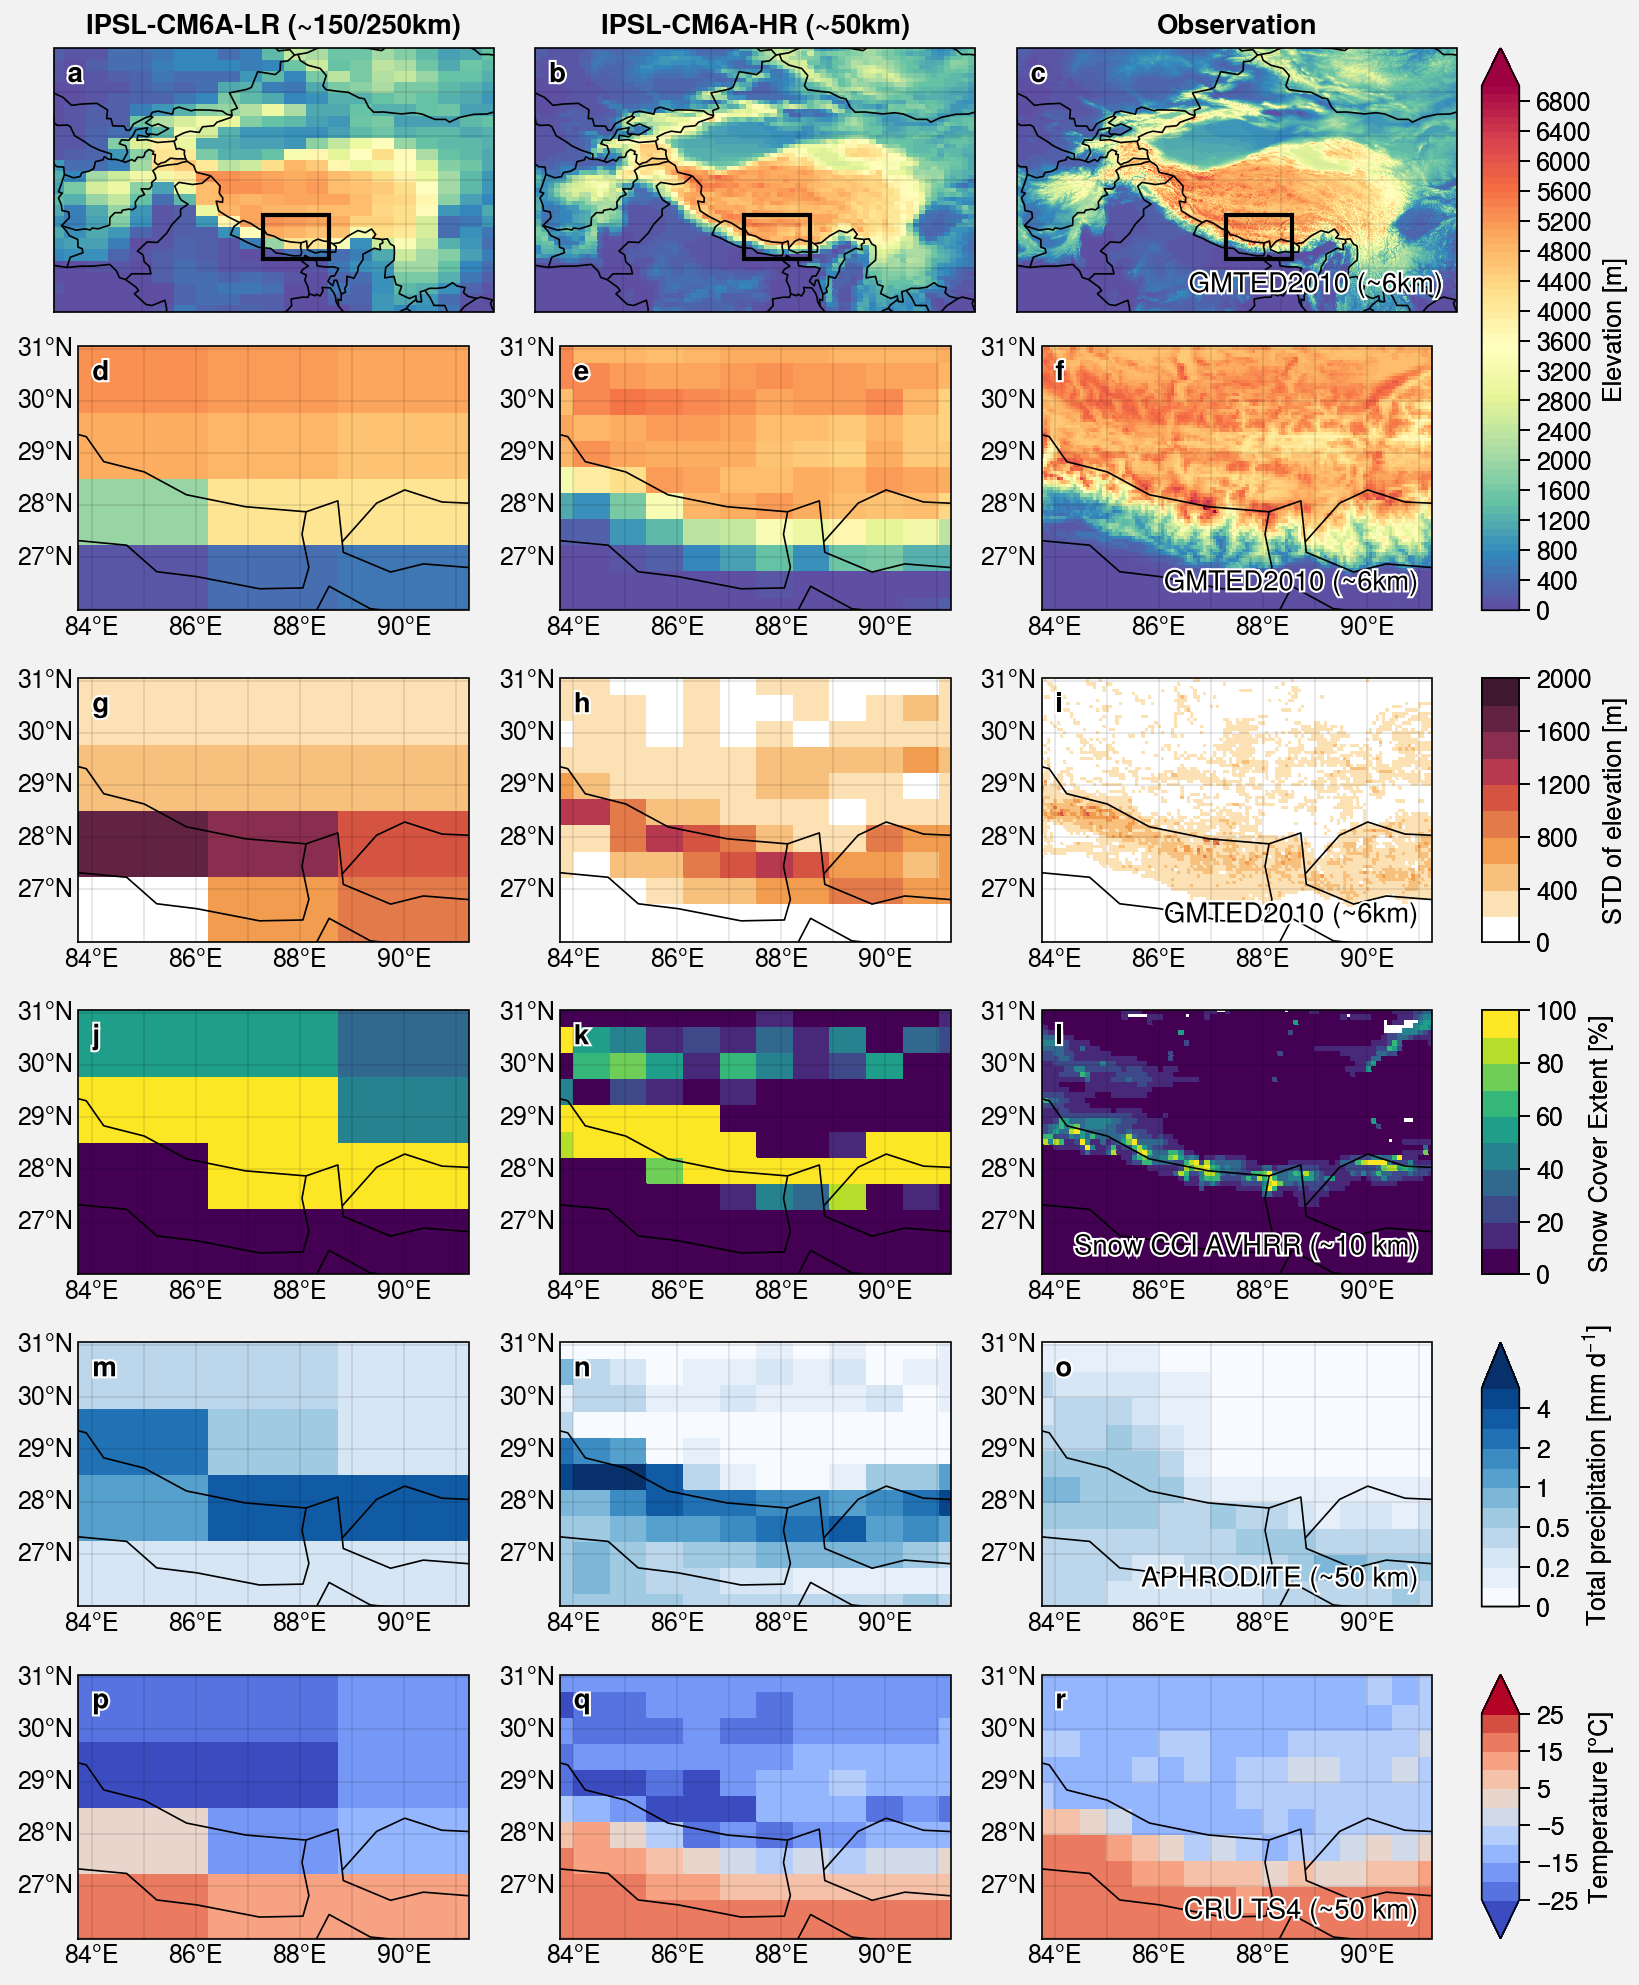

In [65]:
levels=plot.arange(0,7000,100)
cmap='Spectral_r'
extend='max'



f, axs = plot.subplots(proj='cyl', ncols=3, nrows=6, axwidth=2.2)

###########
### HMA ###
###########

# Topo
for i, (topo, title) in enumerate(zip(topo_list, topo_list_title)):
    m = axs[0, i].pcolormesh(topo, levels=levels, cmap=cmap, extend=extend)
    axs[0, i].format(lrtitle=title)
    plot_zone_everest(axs[0, i])

    
###############
### Everest ###
###############

# Topo
for i, (topo, title) in enumerate(zip(topo_list, topo_list_title)):
    m = axs[1, i].pcolormesh(topo.sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)), levels=levels, cmap=cmap, extend=extend)
    axs[1, i].format(lrtitle=title)
f.colorbar(m, label='Elevation [m]', rows=(1,2))

# STD
levels=plot.arange(0,2000,200)
cmap='Fire'
for i, (topo, title) in enumerate(zip(std_list, topo_list_title)):
    m = axs[2, i].pcolormesh(topo.sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)), levels=levels, cmap=cmap)
    axs[2, i].format(lrtitle=title)
f.colorbar(m, label='STD of elevation [m]', row=3)

# snc
cmap='viridis'
levels=plot.arange(0,100,10)
for i, (topo, title) in enumerate(zip(snc_list, snc_list_title)):
    m = axs[3, i].pcolormesh(topo.sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)), levels=levels, cmap=cmap)
    axs[3, i].format(lrtitle=title)
f.colorbar(m, label='Snow Cover Extent [%]', row=4)

# pr
extend='max'
# levels=[0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10]
levels=[0, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5]
cmap = 'Blues'
for i, (topo, title) in enumerate(zip(pr_list, pr_list_title)):
    m = axs[4, i].pcolormesh(topo.sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)), levels=levels, cmap=cmap, extend=extend)
    axs[4, i].format(lrtitle=title)
f.colorbar(m, label='Total precipitation [mm d$^{-1}$]', row=5)

# tas
cmap='CoolWarm'
levels=plot.arange(-25,25,5)
for i, (topo, title) in enumerate(zip(tas_list, tas_list_title)):
    m = axs[5, i].pcolormesh(topo.sel(lat=latlim_everest, lon=slice(85.0-1.25-0.5, 90+1.25+0.5)), levels=levels, cmap=cmap, extend='both')
    axs[5, i].format(lrtitle=title)
f.colorbar(m, label='Temperature [°C]', row=6)


##############
### Format ###
##############

axs[0, :].format(
    labels=False, borders=True, coast=True,
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

axs[1:, :].format(
    labels=True, borders=True, coast=True,
    latlim=(latlim_everest.start, latlim_everest.stop), lonlim=(lonlim_everest.start, lonlim_everest.stop)
)

axs.format(
    abc=True, abcloc='ul',
    collabels=['IPSL-CM6A-LR (~150/250km)', 'IPSL-CM6A-HR (~50km)', 'Observation']
)

f.savefig("img/topo_std_var_everest.jpg")

# Plot 3D

In [12]:
latlim_zoom = slice(26.5,31.7)
lonlim_zoom = slice(82.5,90)

### ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

Mois manquant en 1994/1995 mais ok ici, commence en 1982 (donc 1 an de moins mais ok ici)

In [13]:
%%time
root_data_path = '/data/mlalande/'
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.1deg/*.nc', parallel=True).sel(time=period_clim, lat=latlim_zoom, lon=lonlim_zoom)
# Check if the time steps are ok
# np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
# démarre en 1982

snow_cci_interp = ds['scfg_interp_0.1deg_icefilled']
snow_cci_interp = snow_cci_interp.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2008-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snow_cci_interp.load()
snow_cci_interp.loc['1994-10'] = snow_cci_interp.loc['1994-11'].values
snow_cci_interp_mon = snow_cci_interp.groupby('time.month').mean()

CPU times: user 5.89 s, sys: 1.47 s, total: 7.36 s
Wall time: 40.8 s


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


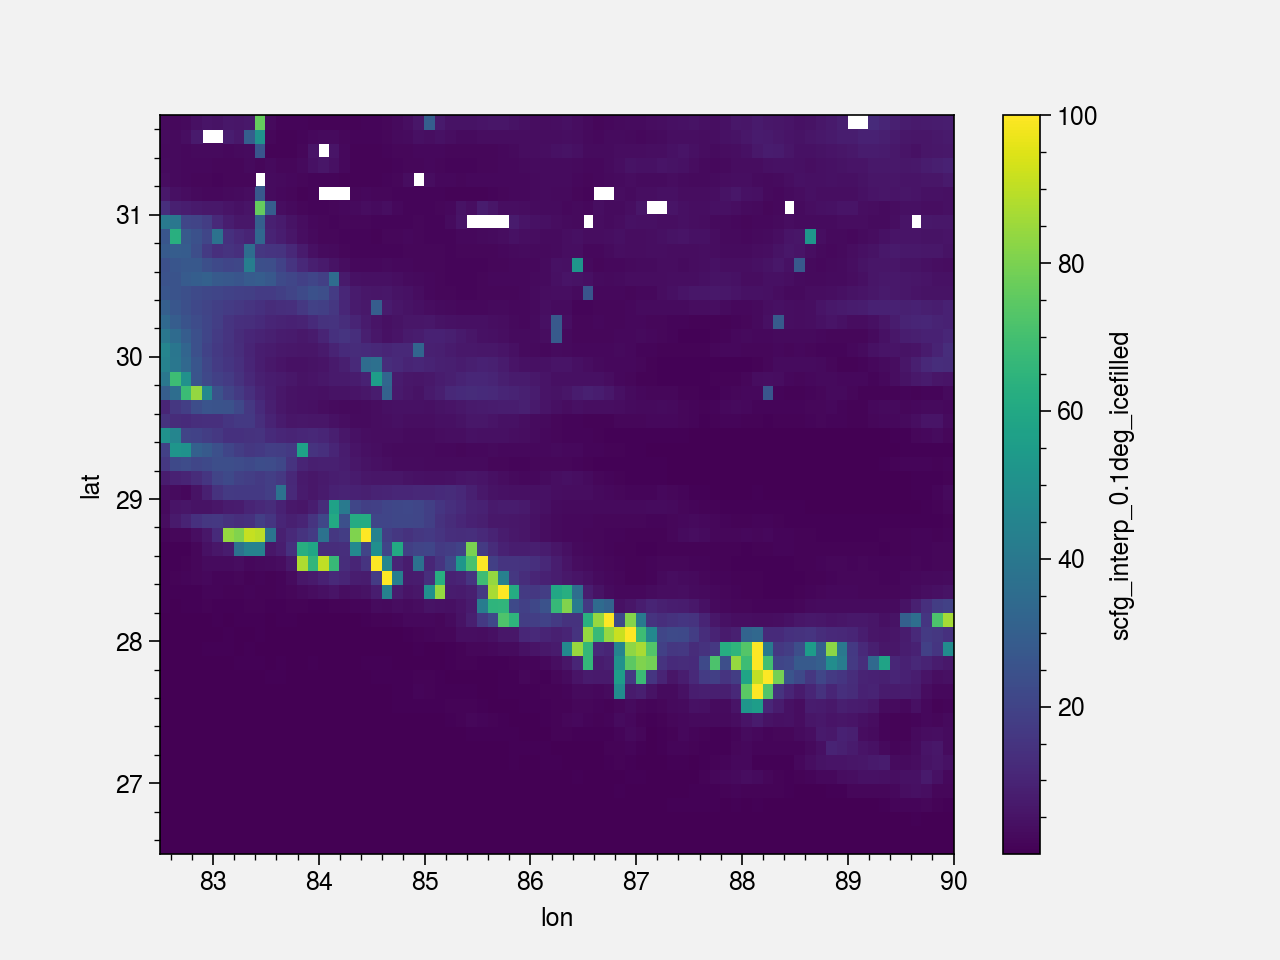

In [39]:
snow_cci_interp.mean('time').plot()

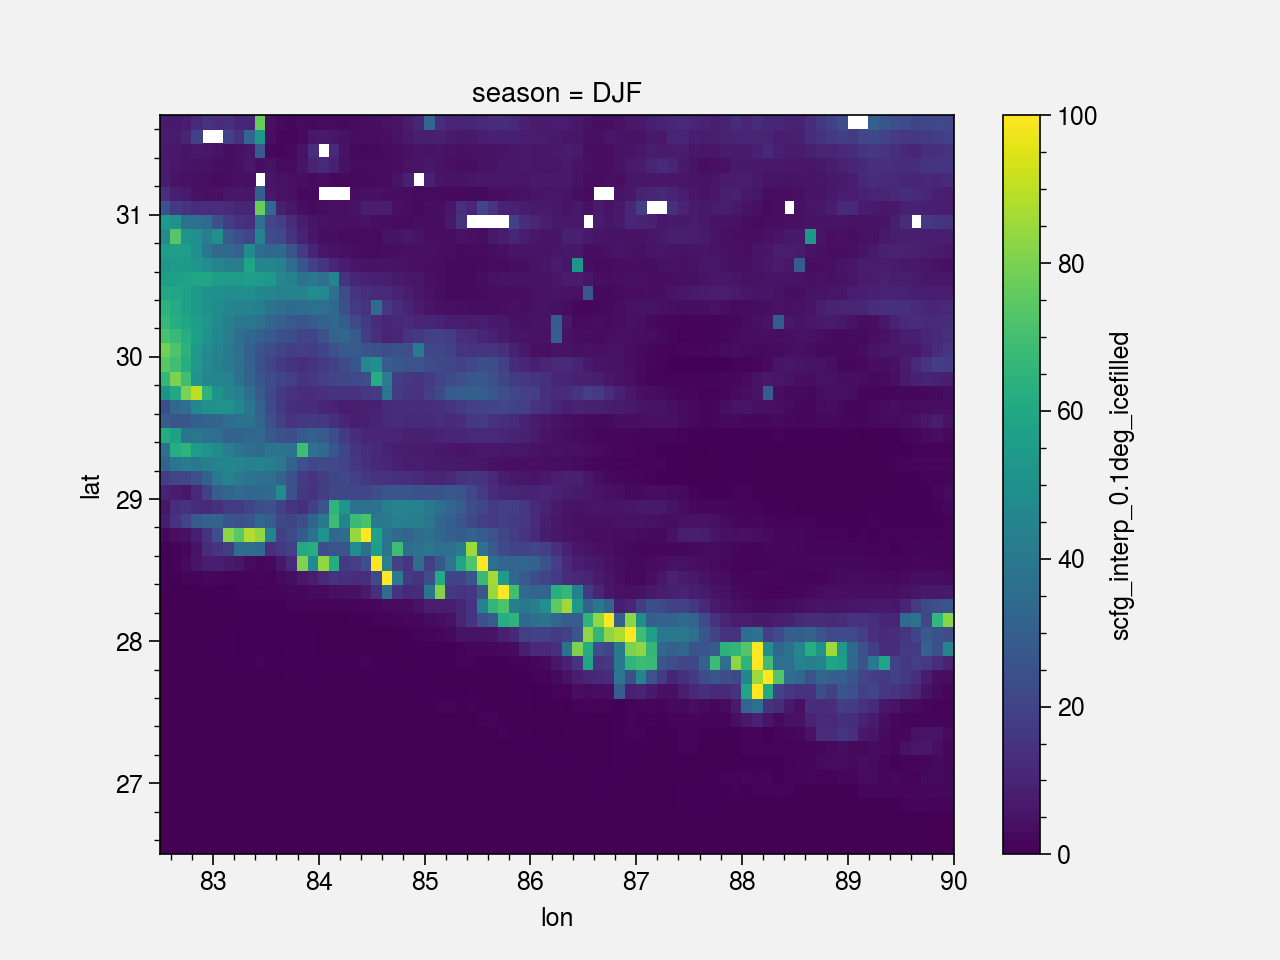

In [40]:
snow_cci_interp.groupby('time.season').mean().sel(season='DJF').plot()

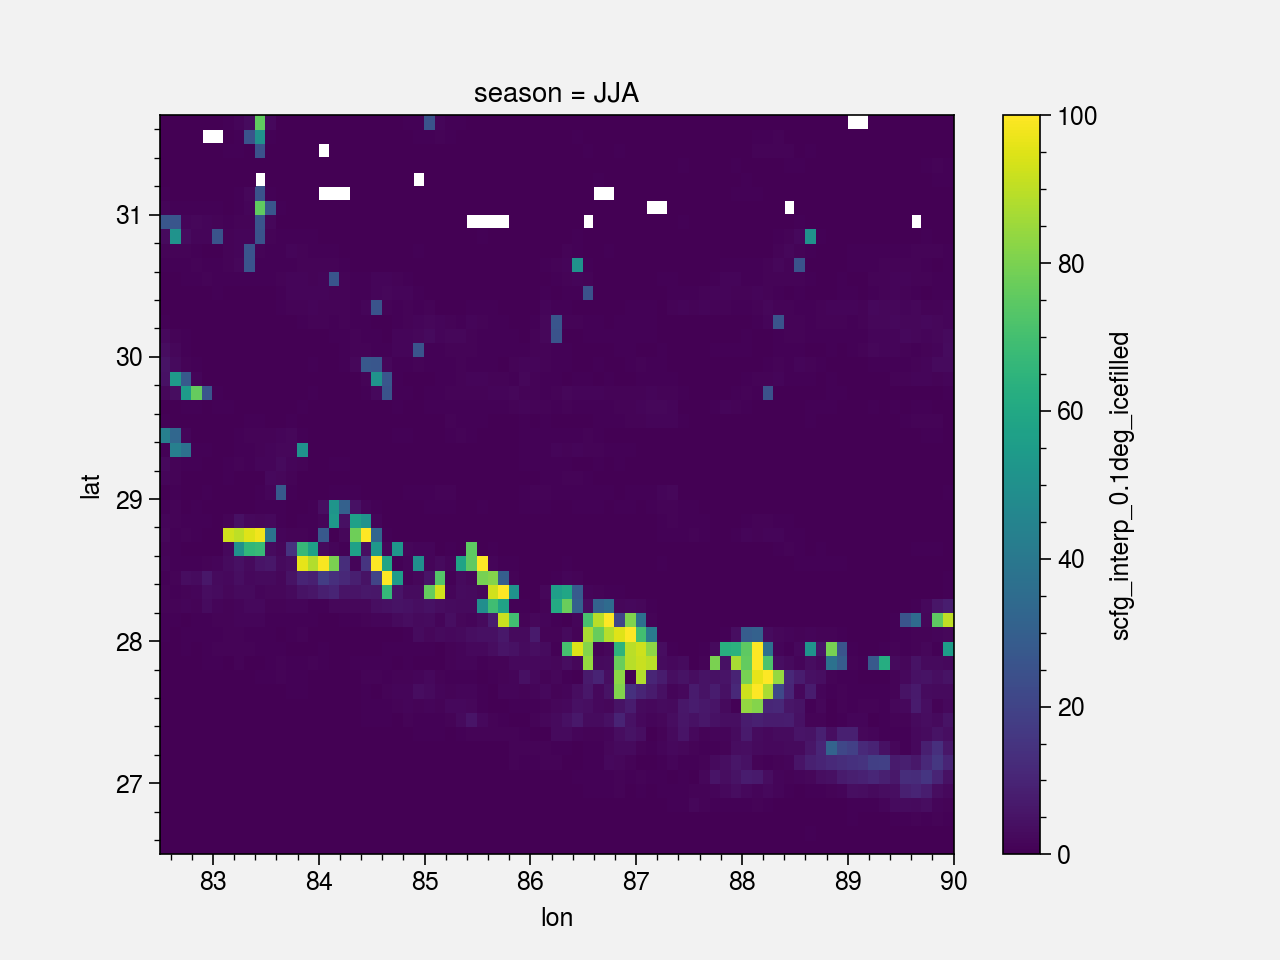

In [41]:
snow_cci_interp.groupby('time.season').mean().sel(season='JJA').plot()

In [14]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'

realization = 'ens'
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
).sel(time=period_clim)

# Load HighResMIP
realization = 'r1i1p1f1'
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period_clim)[var]

In [15]:
avhrr = snow_cci_interp_mon.sel(month=[1, 2, 12]).mean('month').sel(lat=latlim_zoom, lon=lonlim_zoom).load()
snc_LR = da_historical.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_zoom, lon=lonlim_zoom).load()
snc_HR = da_HR.groupby('time.season').mean().sel(season='DJF').sel(lat=latlim_zoom, lon=lonlim_zoom).load()

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [16]:
snc_list = [snc_LR, snc_HR, avhrr]
snc_list_title = ['', '', 'Snow CCI AVHRR (~10 km)']

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.ticker as ticker

In [24]:
def plot_3D(nrows, ncols, position, da, zlim, title=None, cmap=None, fc=None):
    ax = fig.add_subplot(nrows, ncols, position, projection='3d'); ax.grid(False)
    X = da.lon.values; Y = da.lat.values; Z = da.values
    X, Y = np.meshgrid(X, Y)
    if fc is not None:
        m = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=fc)
    if cmap is not None:
        m = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cmap, vmin=0, vmax=7000)
    ax.set_zlim(zlim[0],zlim[1])
    if title is not None:
        ax.text2D(0.05, 0.95, title, transform=ax.transAxes)   
    
    return ax, m

In [19]:
latlim_zoom = slice(26.5,31.7)
lonlim_zoom = slice(82.5,90)

# Regrid obs for projecting on topo
snc_list_regrid = []
for snc in snc_list: 
    regridder = xe.Regridder(snc, topo_gmted.sel(lat=latlim_zoom, lon=lonlim_zoom), 'nearest_s2d', periodic=False, reuse_weights=True)
    snc_regrid = regridder(snc)
    snc_list_regrid.append(snc_regrid)

Reuse existing file: nearest_s2d_5x4_83x120.nc
Reuse existing file: nearest_s2d_11x11_83x120.nc
Reuse existing file: nearest_s2d_52x75_83x120.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [20]:
def make_fc(da, da_max):
    return cm.cubehelix(da/da_max)

fc_max = 100
fc = [make_fc(da, fc_max) for da in snc_list_regrid]

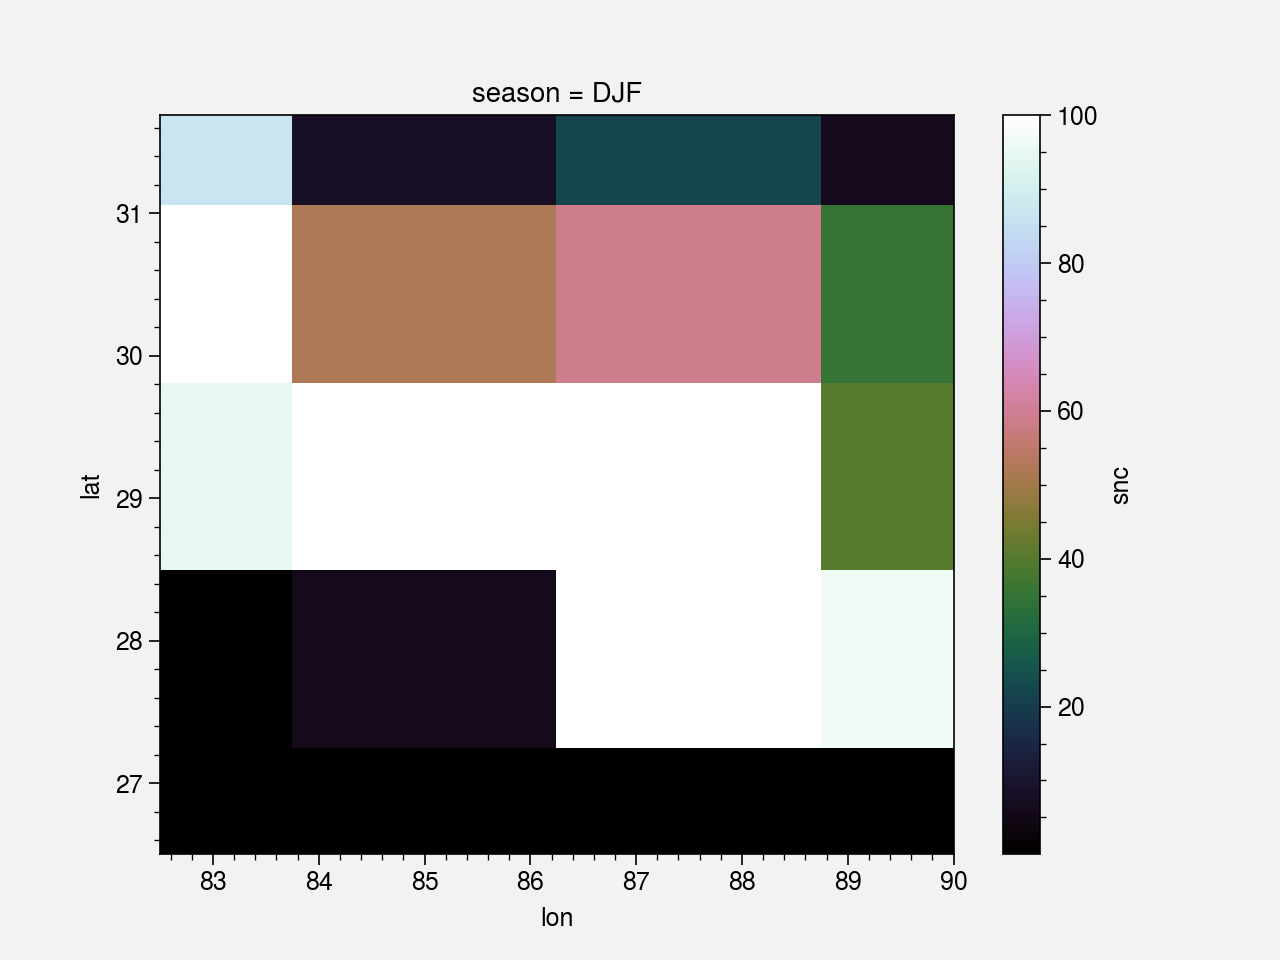

In [33]:
m2 = snc_list_regrid[0].plot(cmap=cm.cubehelix)

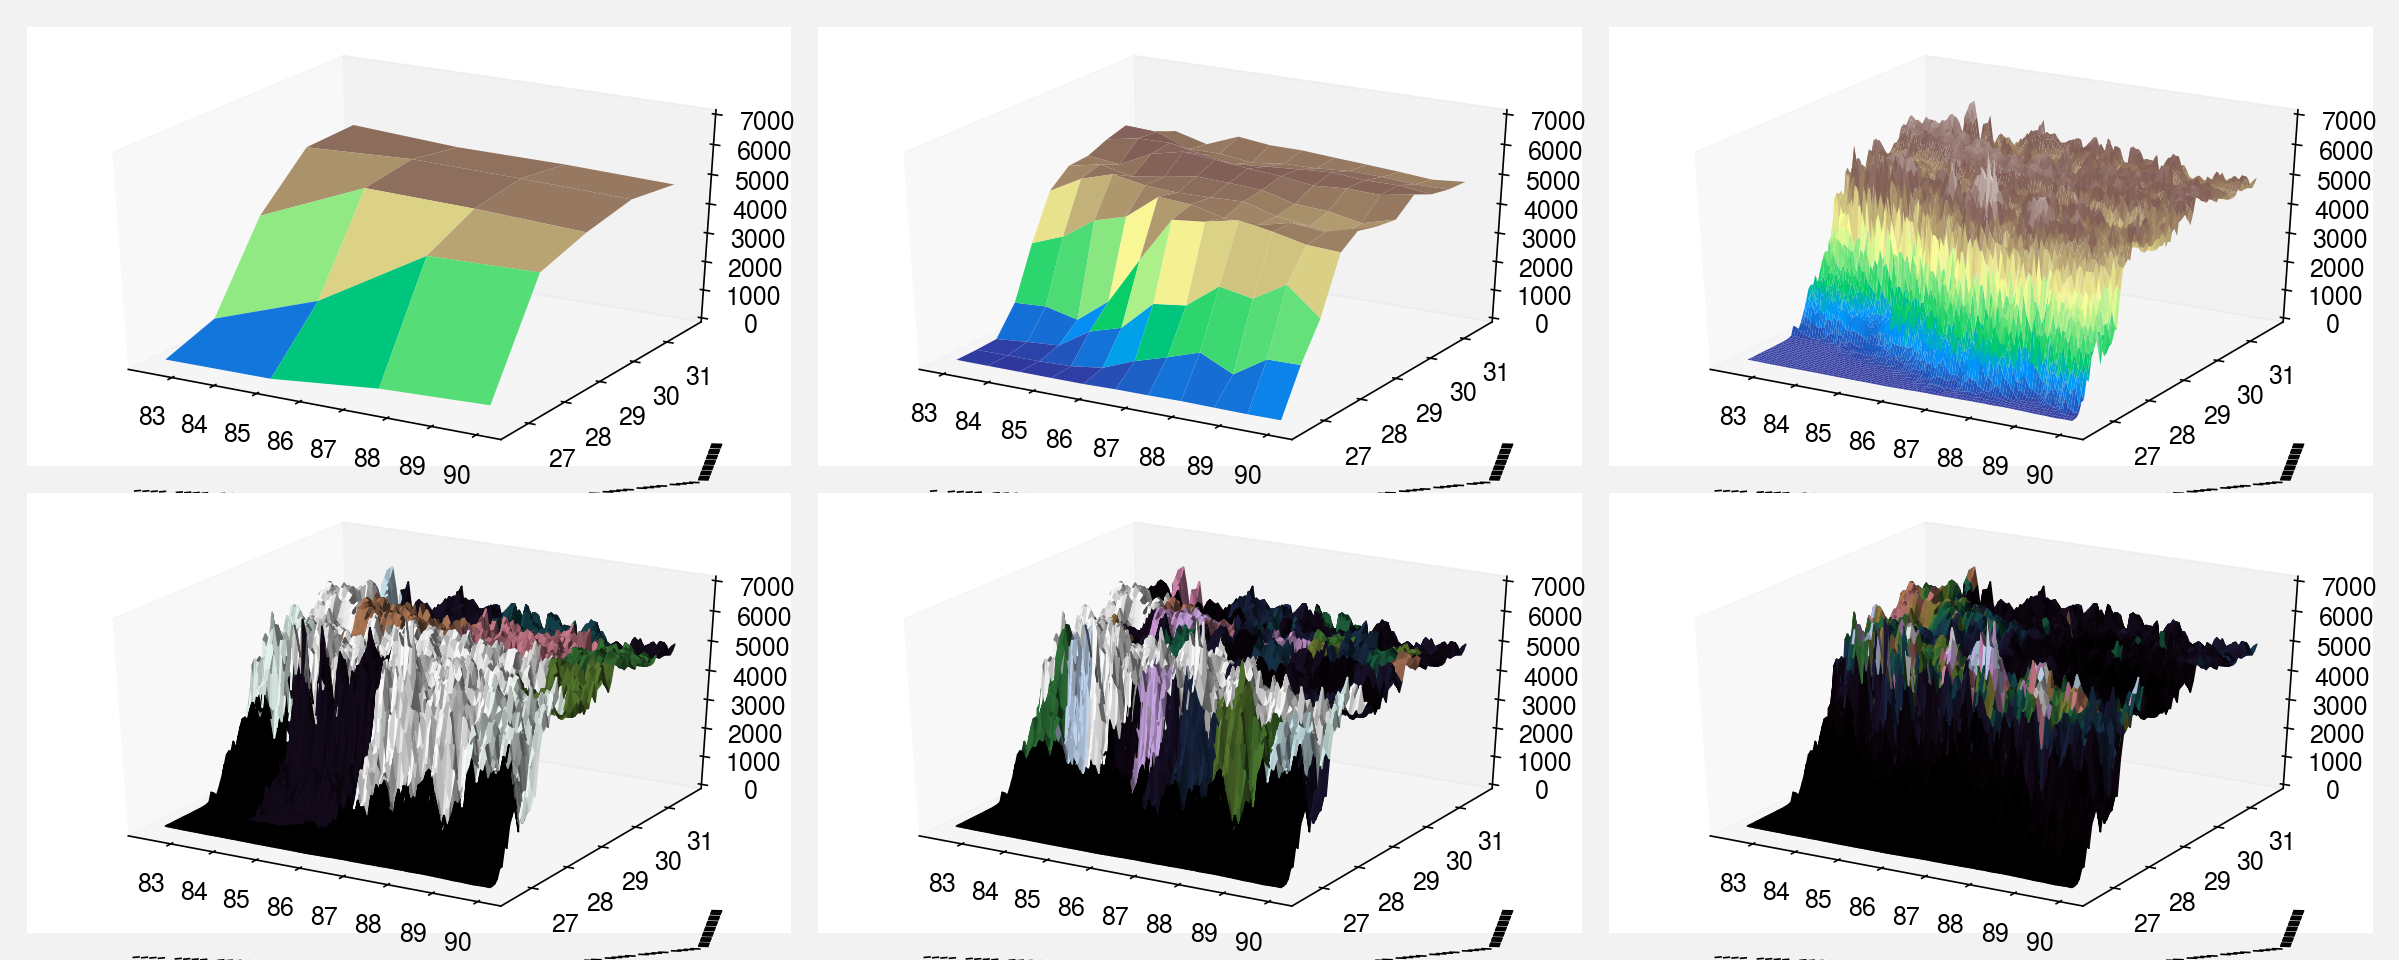

In [127]:
zlim = [0, 7000]

latlim_zoom = slice(26.5,31.7)
lonlim_zoom = slice(82.5,90)

topo_list_everest = [topo.sel(lat=latlim_zoom, lon=lonlim_zoom) for topo in topo_list]

fig = plt.figure(figsize=plt.figaspect(0.4))

for i, topo in enumerate(topo_list_everest):
    m = plot_3D(2, 3, i+1, topo, zlim, title=None, cmap='terrain')
    
for i, f in enumerate(fc):
    m2 = plot_3D(2, 3, i+4, topo_list_everest[2], zlim, title=None, fc=f)

# fig.colorbar(m, 
# #              shrink=0.5, 
# #              aspect=5, 
#              label='Elevation [m]', cax=2)
# fig.colorbar(m2, 
# #              shrink=0.5, 
# #              aspect=5, 
#              label='Snow Cover Extent [%]', cax=5)

plt.tight_layout()
# plt.savefig('img/3D/elevations.jpg', dpi=300)

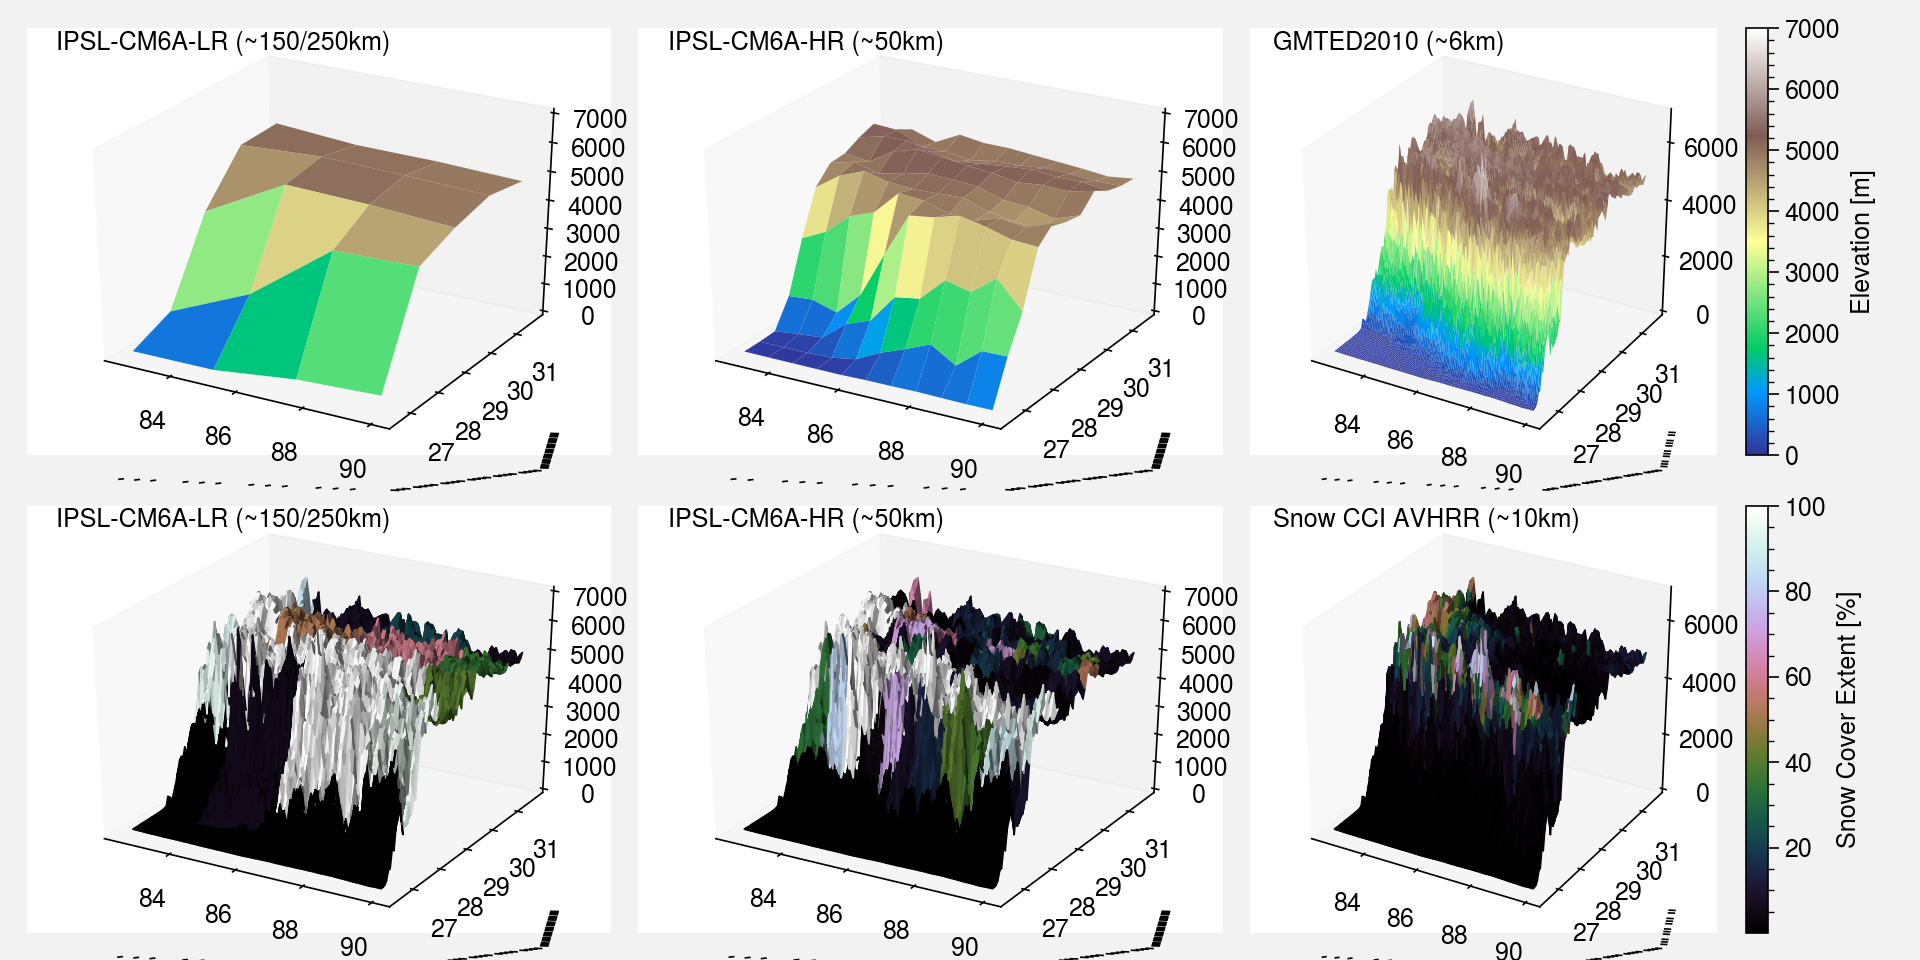

In [37]:
zlim = [0, 7000]

latlim_zoom = slice(26.5,31.7)
lonlim_zoom = slice(82.5,90)

topo_list_everest = [topo.sel(lat=latlim_zoom, lon=lonlim_zoom) for topo in topo_list]
titles1 = ['IPSL-CM6A-LR (~150/250km)', 'IPSL-CM6A-HR (~50km)', 'GMTED2010 (~6km)']
titles2 = ['IPSL-CM6A-LR (~150/250km)', 'IPSL-CM6A-HR (~50km)', 'Snow CCI AVHRR (~10km)']

fig = plt.figure(figsize=plt.figaspect(0.5))

for i, topo in enumerate(topo_list_everest):
    ax, m = plot_3D(2, 3, i+1, topo, zlim, title=titles1[i], cmap='terrain')
    if i == 2:
        fig.colorbar(m, label='Elevation [m]')
    
for i, f in enumerate(fc):
    plot_3D(2, 3, i+4, topo_list_everest[2], zlim, title=titles2[i], fc=f)
    if i == 2:
        fig.colorbar(m2, label='Snow Cover Extent [%]')

plt.tight_layout()
plt.savefig('img/topo_snc_3D_plots.jpg', dpi=300)

Voir : https://landsatlook.usgs.gov/explore?date=2021-10-30%7C2022-10-27 pour vérifier l'enneigement avec Landsat

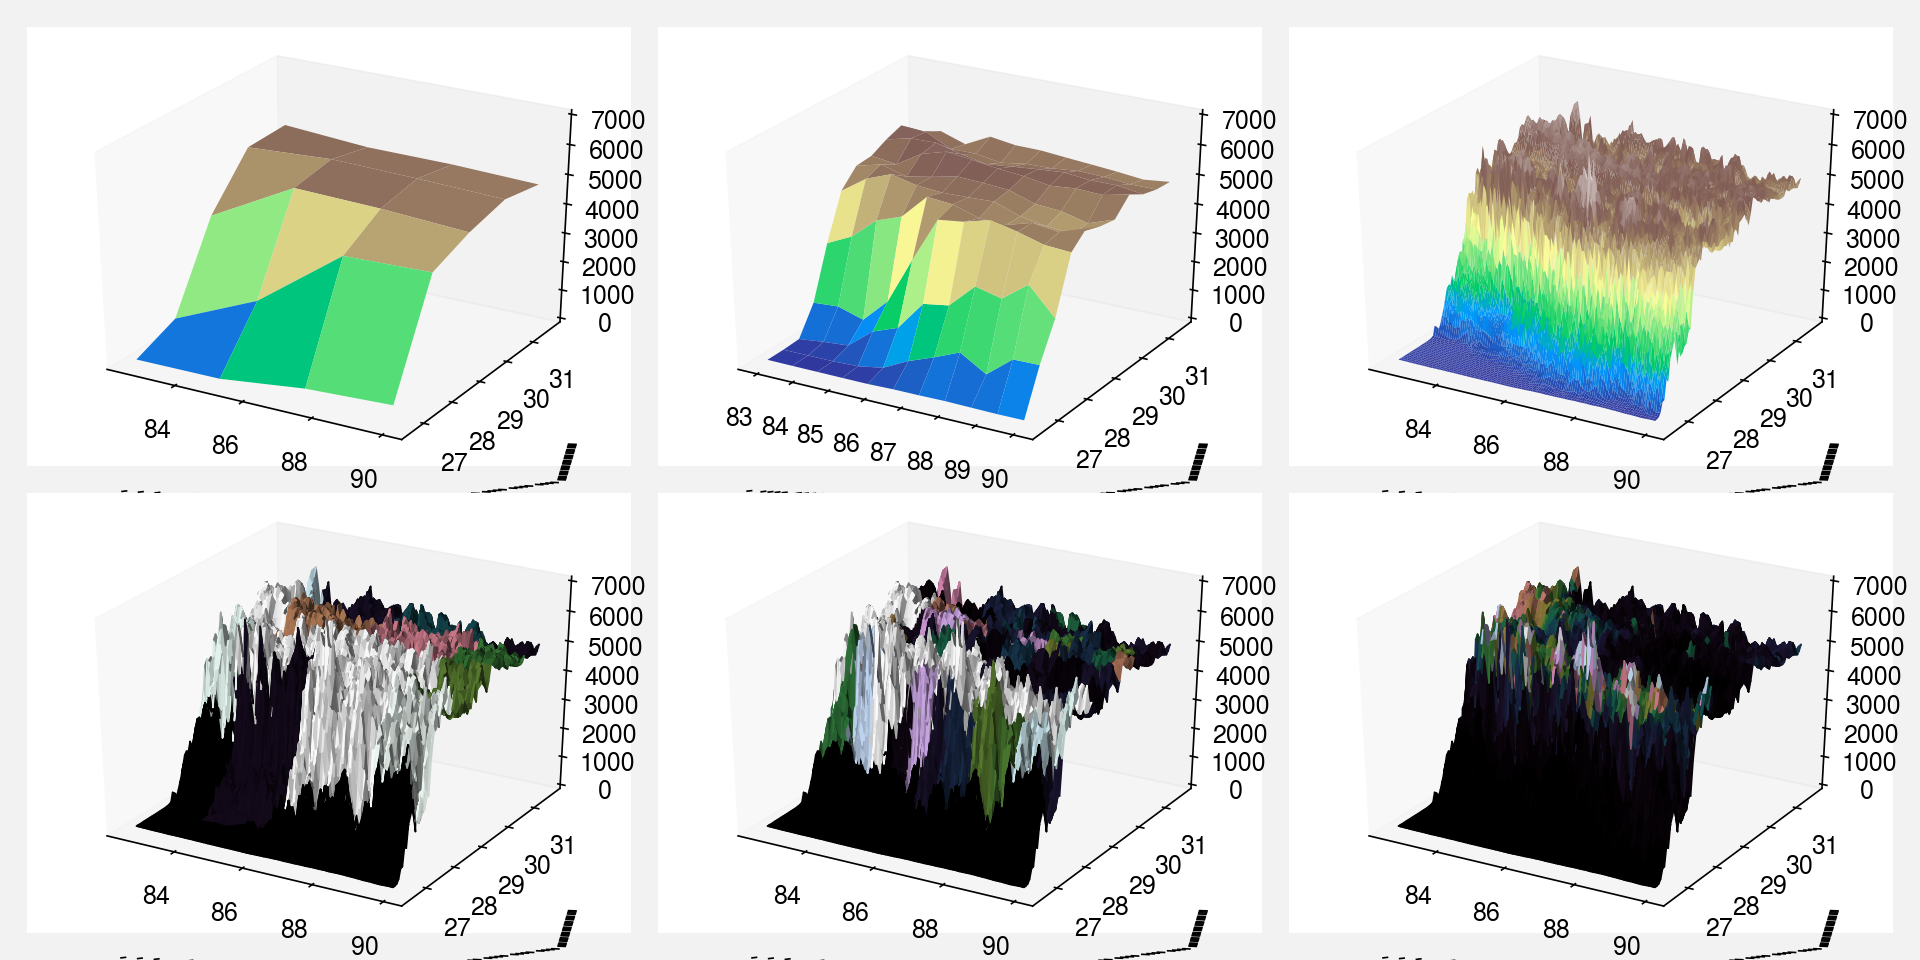

In [128]:
zlim = [0, 7000]

latlim_zoom = slice(26.5,31.7)
lonlim_zoom = slice(82.5,90)

topo_list_everest = [topo.sel(lat=latlim_zoom, lon=lonlim_zoom) for topo in topo_list]

fig = plt.figure(figsize=plt.figaspect(0.5))

for i, topo in enumerate(topo_list_everest):
    m = plot_3D(2, 3, i+1, topo, zlim, title=None, cmap='terrain')
    
for i, f in enumerate(fc):
    m2 = plot_3D(2, 3, i+4, topo_list_everest[2], zlim, title=None, fc=f)

# fig.colorbar(m, 
# #              shrink=0.5, 
# #              aspect=5, 
#              label='Elevation [m]', cax=2)
# fig.colorbar(m2, 
# #              shrink=0.5, 
# #              aspect=5, 
#              label='Snow Cover Extent [%]', cax=5)

plt.tight_layout()
# plt.savefig('img/3D/elevations.jpg', dpi=300)